# Sciplex Dose

In [1]:
ood_seed = 1

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('BMS', '10.0'), 153)


Removed datapoint: 153

train         11699
validation     2959
ood             153
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 62%|██████▏   | 9191/14811 [00:00<00:00, 91907.02it/s]

100%|██████████| 14811/14811 [00:00<00:00, 92553.67it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 997188.25it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 192.97it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<25:19,  3.81s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<25:19,  3.81s/it, v_num=1, recon=3.09e+3, r2_mean=0.131, adv_loss=1.5, acc_pert=0.325]

Epoch 2/400:   0%|          | 1/400 [00:03<25:19,  3.81s/it, v_num=1, recon=3.09e+3, r2_mean=0.131, adv_loss=1.5, acc_pert=0.325]

Epoch 2/400:   0%|          | 2/400 [00:07<23:17,  3.51s/it, v_num=1, recon=3.09e+3, r2_mean=0.131, adv_loss=1.5, acc_pert=0.325]

Epoch 2/400:   0%|          | 2/400 [00:07<23:17,  3.51s/it, v_num=1, recon=2.34e+3, r2_mean=0.487, adv_loss=1.26, acc_pert=0.499]

Epoch 3/400:   0%|          | 2/400 [00:07<23:17,  3.51s/it, v_num=1, recon=2.34e+3, r2_mean=0.487, adv_loss=1.26, acc_pert=0.499]

Epoch 3/400:   1%|          | 3/400 [00:10<22:30,  3.40s/it, v_num=1, recon=2.34e+3, r2_mean=0.487, adv_loss=1.26, acc_pert=0.499]

Epoch 3/400:   1%|          | 3/400 [00:10<22:30,  3.40s/it, v_num=1, recon=2.2e+3, r2_mean=0.607, adv_loss=1.13, acc_pert=0.563] 

Epoch 4/400:   1%|          | 3/400 [00:10<22:30,  3.40s/it, v_num=1, recon=2.2e+3, r2_mean=0.607, adv_loss=1.13, acc_pert=0.563]

Epoch 4/400:   1%|          | 4/400 [00:13<22:11,  3.36s/it, v_num=1, recon=2.2e+3, r2_mean=0.607, adv_loss=1.13, acc_pert=0.563]

Epoch 4/400:   1%|          | 4/400 [00:13<22:11,  3.36s/it, v_num=1, recon=2.16e+3, r2_mean=0.674, adv_loss=1.04, acc_pert=0.604]

Epoch 5/400:   1%|          | 4/400 [00:13<22:11,  3.36s/it, v_num=1, recon=2.16e+3, r2_mean=0.674, adv_loss=1.04, acc_pert=0.604]

Epoch 5/400:   1%|▏         | 5/400 [00:17<22:05,  3.36s/it, v_num=1, recon=2.16e+3, r2_mean=0.674, adv_loss=1.04, acc_pert=0.604]

Epoch 5/400:   1%|▏         | 5/400 [00:17<22:05,  3.36s/it, v_num=1, recon=2.14e+3, r2_mean=0.716, adv_loss=0.987, acc_pert=0.624]

Epoch 6/400:   1%|▏         | 5/400 [00:17<22:05,  3.36s/it, v_num=1, recon=2.14e+3, r2_mean=0.716, adv_loss=0.987, acc_pert=0.624]

Epoch 6/400:   2%|▏         | 6/400 [00:20<21:58,  3.35s/it, v_num=1, recon=2.14e+3, r2_mean=0.716, adv_loss=0.987, acc_pert=0.624]

Epoch 6/400:   2%|▏         | 6/400 [00:20<21:58,  3.35s/it, v_num=1, recon=2.13e+3, r2_mean=0.746, adv_loss=0.942, acc_pert=0.649]

Epoch 7/400:   2%|▏         | 6/400 [00:20<21:58,  3.35s/it, v_num=1, recon=2.13e+3, r2_mean=0.746, adv_loss=0.942, acc_pert=0.649]

Epoch 7/400:   2%|▏         | 7/400 [00:23<21:54,  3.34s/it, v_num=1, recon=2.13e+3, r2_mean=0.746, adv_loss=0.942, acc_pert=0.649]

Epoch 7/400:   2%|▏         | 7/400 [00:23<21:54,  3.34s/it, v_num=1, recon=2.12e+3, r2_mean=0.769, adv_loss=0.912, acc_pert=0.659]

Epoch 8/400:   2%|▏         | 7/400 [00:23<21:54,  3.34s/it, v_num=1, recon=2.12e+3, r2_mean=0.769, adv_loss=0.912, acc_pert=0.659]

Epoch 8/400:   2%|▏         | 8/400 [00:27<21:47,  3.34s/it, v_num=1, recon=2.12e+3, r2_mean=0.769, adv_loss=0.912, acc_pert=0.659]

Epoch 8/400:   2%|▏         | 8/400 [00:27<21:47,  3.34s/it, v_num=1, recon=2.12e+3, r2_mean=0.79, adv_loss=0.892, acc_pert=0.668] 

Epoch 9/400:   2%|▏         | 8/400 [00:27<21:47,  3.34s/it, v_num=1, recon=2.12e+3, r2_mean=0.79, adv_loss=0.892, acc_pert=0.668]

Epoch 9/400:   2%|▏         | 9/400 [00:30<21:49,  3.35s/it, v_num=1, recon=2.12e+3, r2_mean=0.79, adv_loss=0.892, acc_pert=0.668]

Epoch 9/400:   2%|▏         | 9/400 [00:30<21:49,  3.35s/it, v_num=1, recon=2.11e+3, r2_mean=0.802, adv_loss=0.878, acc_pert=0.674]

Epoch 10/400:   2%|▏         | 9/400 [00:30<21:49,  3.35s/it, v_num=1, recon=2.11e+3, r2_mean=0.802, adv_loss=0.878, acc_pert=0.674]


disnt_basal = 0.3846603694125235

disnt_after = 0.3866298571575229

val_r2_mean = 0.8046757961312929

val_r2_var = 0.2827305684487025


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:48<50:44,  7.81s/it, v_num=1, recon=2.11e+3, r2_mean=0.802, adv_loss=0.878, acc_pert=0.674]

Epoch 10/400:   2%|▎         | 10/400 [00:48<50:44,  7.81s/it, v_num=1, recon=2.11e+3, r2_mean=0.816, adv_loss=0.859, acc_pert=0.678, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:48<50:44,  7.81s/it, v_num=1, recon=2.11e+3, r2_mean=0.816, adv_loss=0.859, acc_pert=0.678, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:51<41:56,  6.47s/it, v_num=1, recon=2.11e+3, r2_mean=0.816, adv_loss=0.859, acc_pert=0.678, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:51<41:56,  6.47s/it, v_num=1, recon=2.11e+3, r2_mean=0.827, adv_loss=0.847, acc_pert=0.682, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:51<41:56,  6.47s/it, v_num=1, recon=2.11e+3, r2_mean=0.827, adv_loss=0.847, acc_pert=0.682, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:55<36:50,  5.70s/it, v_num=1, recon=2.11e+3, r2_mean=0.827, adv_loss=0.847, acc_pert=0.682, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:55<36:50,  5.70s/it, v_num=1, recon=2.1e+3, r2_mean=0.838, adv_loss=0.841, acc_pert=0.688, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:55<36:50,  5.70s/it, v_num=1, recon=2.1e+3, r2_mean=0.838, adv_loss=0.841, acc_pert=0.688, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:58<31:59,  4.96s/it, v_num=1, recon=2.1e+3, r2_mean=0.838, adv_loss=0.841, acc_pert=0.688, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:58<31:59,  4.96s/it, v_num=1, recon=2.1e+3, r2_mean=0.846, adv_loss=0.83, acc_pert=0.69, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]  

Epoch 14/400:   3%|▎         | 13/400 [00:58<31:59,  4.96s/it, v_num=1, recon=2.1e+3, r2_mean=0.846, adv_loss=0.83, acc_pert=0.69, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:02<28:40,  4.46s/it, v_num=1, recon=2.1e+3, r2_mean=0.846, adv_loss=0.83, acc_pert=0.69, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:02<28:40,  4.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.854, adv_loss=0.821, acc_pert=0.697, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:02<28:40,  4.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.854, adv_loss=0.821, acc_pert=0.697, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:05<26:22,  4.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.854, adv_loss=0.821, acc_pert=0.697, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:05<26:22,  4.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.86, adv_loss=0.81, acc_pert=0.702, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]  

Epoch 16/400:   4%|▍         | 15/400 [01:05<26:22,  4.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.86, adv_loss=0.81, acc_pert=0.702, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:08<24:41,  3.86s/it, v_num=1, recon=2.09e+3, r2_mean=0.86, adv_loss=0.81, acc_pert=0.702, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:08<24:41,  3.86s/it, v_num=1, recon=2.09e+3, r2_mean=0.865, adv_loss=0.807, acc_pert=0.696, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:08<24:41,  3.86s/it, v_num=1, recon=2.09e+3, r2_mean=0.865, adv_loss=0.807, acc_pert=0.696, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:11<23:26,  3.67s/it, v_num=1, recon=2.09e+3, r2_mean=0.865, adv_loss=0.807, acc_pert=0.696, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:11<23:26,  3.67s/it, v_num=1, recon=2.09e+3, r2_mean=0.87, adv_loss=0.802, acc_pert=0.697, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [01:11<23:26,  3.67s/it, v_num=1, recon=2.09e+3, r2_mean=0.87, adv_loss=0.802, acc_pert=0.697, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:15<23:11,  3.64s/it, v_num=1, recon=2.09e+3, r2_mean=0.87, adv_loss=0.802, acc_pert=0.697, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:15<23:11,  3.64s/it, v_num=1, recon=2.08e+3, r2_mean=0.872, adv_loss=0.797, acc_pert=0.703, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:15<23:11,  3.64s/it, v_num=1, recon=2.08e+3, r2_mean=0.872, adv_loss=0.797, acc_pert=0.703, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:19<23:01,  3.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.872, adv_loss=0.797, acc_pert=0.703, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:19<23:01,  3.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.876, adv_loss=0.789, acc_pert=0.707, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:19<23:01,  3.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.876, adv_loss=0.789, acc_pert=0.707, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]


disnt_basal = 0.4081148851053462

disnt_after = 0.4098557785983398

val_r2_mean = 0.8557421525319416

val_r2_var = 0.3414063349366188


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:36<48:17,  7.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.876, adv_loss=0.789, acc_pert=0.707, val_recon=2.11e+3, disnt_basal=0.385, disnt_after=0.387, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:36<48:17,  7.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.878, adv_loss=0.783, acc_pert=0.707, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:36<48:17,  7.63s/it, v_num=1, recon=2.08e+3, r2_mean=0.878, adv_loss=0.783, acc_pert=0.707, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:39<40:29,  6.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.878, adv_loss=0.783, acc_pert=0.707, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:39<40:29,  6.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.88, adv_loss=0.776, acc_pert=0.712, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [01:39<40:29,  6.41s/it, v_num=1, recon=2.08e+3, r2_mean=0.88, adv_loss=0.776, acc_pert=0.712, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:43<34:56,  5.55s/it, v_num=1, recon=2.08e+3, r2_mean=0.88, adv_loss=0.776, acc_pert=0.712, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:43<34:56,  5.55s/it, v_num=1, recon=2.07e+3, r2_mean=0.881, adv_loss=0.773, acc_pert=0.71, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:43<34:56,  5.55s/it, v_num=1, recon=2.07e+3, r2_mean=0.881, adv_loss=0.773, acc_pert=0.71, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:46<30:41,  4.89s/it, v_num=1, recon=2.07e+3, r2_mean=0.881, adv_loss=0.773, acc_pert=0.71, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:46<30:41,  4.89s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.768, acc_pert=0.715, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:46<30:41,  4.89s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.768, acc_pert=0.715, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:49<27:47,  4.44s/it, v_num=1, recon=2.07e+3, r2_mean=0.882, adv_loss=0.768, acc_pert=0.715, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:49<27:47,  4.44s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.764, acc_pert=0.715, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:49<27:47,  4.44s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.764, acc_pert=0.715, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:53<25:44,  4.12s/it, v_num=1, recon=2.07e+3, r2_mean=0.883, adv_loss=0.764, acc_pert=0.715, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:53<25:44,  4.12s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.759, acc_pert=0.718, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:53<25:44,  4.12s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.759, acc_pert=0.718, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:56<24:27,  3.92s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.759, acc_pert=0.718, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:56<24:27,  3.92s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.759, acc_pert=0.713, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:56<24:27,  3.92s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.759, acc_pert=0.713, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:00<23:15,  3.74s/it, v_num=1, recon=2.07e+3, r2_mean=0.885, adv_loss=0.759, acc_pert=0.713, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:00<23:15,  3.74s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.751, acc_pert=0.728, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:00<23:15,  3.74s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.751, acc_pert=0.728, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:03<22:26,  3.62s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.751, acc_pert=0.728, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:03<22:26,  3.62s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.749, acc_pert=0.723, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [02:03<22:26,  3.62s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.749, acc_pert=0.723, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:06<21:50,  3.53s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.749, acc_pert=0.723, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:06<21:50,  3.53s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.741, acc_pert=0.727, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:06<21:50,  3.53s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.741, acc_pert=0.727, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]


disnt_basal = 0.42061621200383814

disnt_after = 0.42194030842218044

val_r2_mean = 0.8739340821901956

val_r2_var = 0.3624145279328029


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:22<43:48,  7.10s/it, v_num=1, recon=2.06e+3, r2_mean=0.887, adv_loss=0.741, acc_pert=0.727, val_recon=2.11e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.856, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:22<43:48,  7.10s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.739, acc_pert=0.729, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:22<43:48,  7.10s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.739, acc_pert=0.729, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:25<36:54,  6.00s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.739, acc_pert=0.729, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:25<36:54,  6.00s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.735, acc_pert=0.729, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:25<36:54,  6.00s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.735, acc_pert=0.729, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:28<31:58,  5.21s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.735, acc_pert=0.729, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:28<31:58,  5.21s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.735, acc_pert=0.728, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [02:28<31:58,  5.21s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.735, acc_pert=0.728, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:32<28:25,  4.65s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.735, acc_pert=0.728, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:32<28:25,  4.65s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.734, acc_pert=0.726, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:32<28:25,  4.65s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.734, acc_pert=0.726, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:35<25:58,  4.26s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.734, acc_pert=0.726, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:35<25:58,  4.26s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.729, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:35<25:58,  4.26s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.729, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:38<24:11,  3.98s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.729, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:38<24:11,  3.98s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.726, acc_pert=0.732, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:38<24:11,  3.98s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.726, acc_pert=0.732, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:42<22:54,  3.78s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.726, acc_pert=0.732, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:42<22:54,  3.78s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:42<22:54,  3.78s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:45<21:59,  3.64s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.727, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:45<21:59,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.728, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:45<21:59,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.728, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:48<21:20,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.728, acc_pert=0.733, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:48<21:20,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.718, acc_pert=0.736, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:48<21:20,  3.54s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.718, acc_pert=0.736, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:52<20:51,  3.47s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.718, acc_pert=0.736, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:52<20:51,  3.47s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.722, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:52<20:51,  3.47s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.722, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]


disnt_basal = 0.42283599068493655

disnt_after = 0.4244493708363964

val_r2_mean = 0.8784689962863923

val_r2_var = 0.37722057501475015


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:08<43:39,  7.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.722, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.874, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:08<43:39,  7.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.723, acc_pert=0.731, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:08<43:39,  7.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.723, acc_pert=0.731, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:11<36:29,  6.10s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.723, acc_pert=0.731, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:11<36:29,  6.10s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:11<36:29,  6.10s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:15<31:28,  5.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.724, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:15<31:28,  5.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.714, acc_pert=0.734, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:15<31:28,  5.28s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.714, acc_pert=0.734, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:18<27:54,  4.69s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.714, acc_pert=0.734, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:18<27:54,  4.69s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.716, acc_pert=0.731, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:18<27:54,  4.69s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.716, acc_pert=0.731, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:21<25:38,  4.32s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.716, acc_pert=0.731, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:21<25:38,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.711, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:21<25:38,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.711, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:25<23:49,  4.03s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.711, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:25<23:49,  4.03s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.708, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:25<23:49,  4.03s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.708, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:28<22:29,  3.81s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.708, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:28<22:29,  3.81s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:28<22:29,  3.81s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:31<21:33,  3.66s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.718, acc_pert=0.734, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:31<21:33,  3.66s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.711, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:31<21:33,  3.66s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.711, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:35<21:17,  3.63s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.711, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:35<21:17,  3.63s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.707, acc_pert=0.735, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:35<21:17,  3.63s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.707, acc_pert=0.735, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:38<20:38,  3.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.707, acc_pert=0.735, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:38<20:38,  3.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.735, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:38<20:38,  3.53s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.735, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.4231148326909897

disnt_after = 0.4243166711791311

val_r2_mean = 0.871470778187116

val_r2_var = 0.38212130914131803

Epoch 50/400:  12%|█▎        | 50/400 [04:08<1:06:55, 11.47s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.735, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.878, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:08<1:06:55, 11.47s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.712, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:08<1:06:55, 11.47s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.712, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:11<52:31,  9.03s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.712, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]  

Epoch 51/400:  13%|█▎        | 51/400 [04:11<52:31,  9.03s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.739, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:11<52:31,  9.03s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.739, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:15<42:27,  7.32s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.703, acc_pert=0.739, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:15<42:27,  7.32s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:15<42:27,  7.32s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:18<35:44,  6.18s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.709, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:18<35:44,  6.18s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.711, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:18<35:44,  6.18s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.711, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:22<30:47,  5.34s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.711, acc_pert=0.737, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:22<30:47,  5.34s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.706, acc_pert=0.74, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [04:22<30:47,  5.34s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.706, acc_pert=0.74, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:25<27:12,  4.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.706, acc_pert=0.74, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:25<27:12,  4.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.74, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:25<27:12,  4.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.74, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:29<25:04,  4.37s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.706, acc_pert=0.74, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:29<25:04,  4.37s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.739, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:29<25:04,  4.37s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.739, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:32<23:14,  4.06s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.739, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:32<23:14,  4.06s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:32<23:14,  4.06s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:35<21:55,  3.85s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.702, acc_pert=0.736, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:35<21:55,  3.85s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.742, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]  

Epoch 59/400:  14%|█▍        | 58/400 [04:35<21:55,  3.85s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.742, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:39<20:52,  3.67s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.742, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:39<20:52,  3.67s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:39<20:52,  3.67s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]


disnt_basal = 0.4262367143507822

disnt_after = 0.4281565224066745

val_r2_mean = 0.8842625737190248

val_r2_var = 0.3978970512747764


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:00<50:24,  8.90s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.705, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.423, disnt_after=0.424, val_r2_mean=0.871, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:00<50:24,  8.90s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.699, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [05:00<50:24,  8.90s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.699, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:03<41:10,  7.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.699, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:03<41:10,  7.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]  

Epoch 62/400:  15%|█▌        | 61/400 [05:03<41:10,  7.29s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:07<34:30,  6.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.7, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:07<34:30,  6.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:07<34:30,  6.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:14<37:10,  6.62s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.696, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:14<37:10,  6.62s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:14<37:10,  6.62s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:18<31:40,  5.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.698, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:18<31:40,  5.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.706, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:18<31:40,  5.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.706, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:21<27:36,  4.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.706, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:21<27:36,  4.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.693, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:21<27:36,  4.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.693, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:24<24:48,  4.46s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.693, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:24<24:48,  4.46s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.694, acc_pert=0.736, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:24<24:48,  4.46s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.694, acc_pert=0.736, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:28<22:45,  4.10s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.694, acc_pert=0.736, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:28<22:45,  4.10s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:28<22:45,  4.10s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:31<21:24,  3.87s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.697, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:31<21:24,  3.87s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.695, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:31<21:24,  3.87s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.695, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:34<20:22,  3.69s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.695, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:34<20:22,  3.69s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]   

Epoch 70/400:  17%|█▋        | 69/400 [05:34<20:22,  3.69s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4248605050208825

disnt_after = 0.4263912863444606

val_r2_mean = 0.8842896008243163

val_r2_var = 0.4081412321577469


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:54<46:58,  8.54s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.884, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:54<46:58,  8.54s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [05:54<46:58,  8.54s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:58<38:46,  7.07s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.696, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:58<38:46,  7.07s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [05:58<38:46,  7.07s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:01<33:12,  6.07s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:01<33:12,  6.07s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:01<33:12,  6.07s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:05<28:29,  5.23s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:05<28:29,  5.23s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [06:05<28:29,  5.23s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:08<25:13,  4.64s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.692, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:08<25:13,  4.64s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [06:08<25:13,  4.64s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:11<22:58,  4.24s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.692, acc_pert=0.745, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:11<22:58,  4.24s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [06:11<22:58,  4.24s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:15<21:14,  3.94s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.744, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:15<21:14,  3.94s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.696, acc_pert=0.737, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [06:15<21:14,  3.94s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.696, acc_pert=0.737, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:18<20:04,  3.73s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.696, acc_pert=0.737, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:18<20:04,  3.73s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:18<20:04,  3.73s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:21<19:13,  3.58s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.684, acc_pert=0.746, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:21<19:13,  3.58s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:21<19:13,  3.58s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:24<18:42,  3.50s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.743, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:24<18:42,  3.50s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:24<18:42,  3.50s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4190022376894862

disnt_after = 0.42047976741373044

val_r2_mean = 0.8827643553415934

val_r2_var = 0.4073776394128799

Epoch 80/400:  20%|██        | 80/400 [06:43<43:16,  8.11s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.691, acc_pert=0.741, val_recon=2.05e+3, disnt_basal=0.425, disnt_after=0.426, val_r2_mean=0.884, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:43<43:16,  8.11s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [06:43<43:16,  8.11s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:46<35:21,  6.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.691, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:46<35:21,  6.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [06:46<35:21,  6.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:50<30:01,  5.66s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.69, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:50<30:01,  5.66s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:50<30:01,  5.66s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:53<26:08,  4.95s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:53<26:08,  4.95s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [06:53<26:08,  4.95s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:56<23:24,  4.45s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.748, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:56<23:24,  4.45s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]  

Epoch 85/400:  21%|██        | 84/400 [06:56<23:24,  4.45s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:00<21:27,  4.09s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.679, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:00<21:27,  4.09s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:00<21:27,  4.09s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:03<20:07,  3.85s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.749, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:03<20:07,  3.85s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:03<20:07,  3.85s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:06<19:13,  3.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.747, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:06<19:13,  3.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [07:06<19:13,  3.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:11<20:10,  3.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.676, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:11<20:10,  3.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:11<20:10,  3.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:14<19:09,  3.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.68, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:14<19:09,  3.70s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.679, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:14<19:09,  3.70s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.679, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.42382065252635454

disnt_after = 0.4256875398984001

val_r2_mean = 0.8883078371485075

val_r2_var = 0.4159368226925532


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [07:37<48:48,  9.45s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.679, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.42, val_r2_mean=0.883, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:37<48:48,  9.45s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.681, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [07:37<48:48,  9.45s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.681, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:40<39:06,  7.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.681, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:40<39:06,  7.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]    

Epoch 92/400:  23%|██▎       | 91/400 [07:40<39:06,  7.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:43<32:19,  6.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:43<32:19,  6.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:43<32:19,  6.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:47<27:40,  5.41s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.675, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:47<27:40,  5.41s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:47<27:40,  5.41s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:50<25:01,  4.91s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.682, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:50<25:01,  4.91s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [07:50<25:01,  4.91s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:54<22:27,  4.42s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.681, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:54<22:27,  4.42s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [07:54<22:27,  4.42s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:57<20:32,  4.06s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:57<20:32,  4.06s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [07:57<20:32,  4.06s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:00<19:21,  3.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.677, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:00<19:21,  3.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:00<19:21,  3.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:03<18:37,  3.70s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:03<18:37,  3.70s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:03<18:37,  3.70s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:07<17:58,  3.58s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:07<17:58,  3.58s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]   

Epoch 100/400:  25%|██▍       | 99/400 [08:07<17:58,  3.58s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4275400631841264

disnt_after = 0.4292197708864249

val_r2_mean = 0.8845338121056557

val_r2_var = 0.4182636251052221

Epoch 100/400:  25%|██▌       | 100/400 [08:22<35:55,  7.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.68, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.888, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:22<35:55,  7.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:22<35:55,  7.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:26<30:27,  6.11s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.681, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:26<30:27,  6.11s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]   

Epoch 102/400:  25%|██▌       | 101/400 [08:26<30:27,  6.11s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:29<26:22,  5.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.67, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:29<26:22,  5.31s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:29<26:22,  5.31s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:33<23:30,  4.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:33<23:30,  4.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]  

Epoch 104/400:  26%|██▌       | 103/400 [08:33<23:30,  4.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:36<21:28,  4.35s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.678, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:36<21:28,  4.35s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:36<21:28,  4.35s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:40<20:05,  4.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:40<20:05,  4.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:40<20:05,  4.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:43<18:55,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.672, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:43<18:55,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:43<18:55,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:46<18:01,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:46<18:01,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [08:46<18:01,  3.69s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:50<17:32,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:50<17:32,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:50<17:32,  3.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:53<17:06,  3.53s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.669, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:53<17:06,  3.53s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]  

Epoch 110/400:  27%|██▋       | 109/400 [08:53<17:06,  3.53s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4223815445239767

disnt_after = 0.42377518940411124

val_r2_mean = 0.8875362450877825

val_r2_var = 0.4186839506030083


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [09:24<56:21, 11.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.665, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.428, disnt_after=0.429, val_r2_mean=0.885, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:24<56:21, 11.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:24<56:21, 11.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:27<44:15,  9.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:27<44:15,  9.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:27<44:15,  9.19s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:30<35:40,  7.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:30<35:40,  7.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:30<35:40,  7.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:34<29:48,  6.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:34<29:48,  6.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [09:34<29:48,  6.23s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:37<25:49,  5.42s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:37<25:49,  5.42s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:37<25:49,  5.42s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:41<22:46,  4.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:41<22:46,  4.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:41<22:46,  4.79s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:44<20:33,  4.34s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:44<20:33,  4.34s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [09:44<20:33,  4.34s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:48<19:12,  4.07s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.665, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:48<19:12,  4.07s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:48<19:12,  4.07s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:51<18:12,  3.87s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.663, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:51<18:12,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [09:51<18:12,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:54<17:23,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:54<17:23,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:54<17:23,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.42153457714217407

disnt_after = 0.42360231460376346

val_r2_mean = 0.8849388445417086

val_r2_var = 0.42320381551980973


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [10:12<37:24,  8.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.888, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:12<37:24,  8.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.662, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [10:12<37:24,  8.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.662, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:16<30:46,  6.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.662, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:16<30:46,  6.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:16<30:46,  6.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:19<26:13,  5.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:19<26:13,  5.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [10:19<26:13,  5.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:23<23:02,  4.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:23<23:02,  4.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [10:23<23:02,  4.99s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:26<20:53,  4.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:26<20:53,  4.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [10:26<20:53,  4.54s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:30<19:31,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:30<19:31,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [10:30<19:31,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:33<18:18,  4.01s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:33<18:18,  4.01s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:33<18:18,  4.01s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:37<17:34,  3.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:37<17:34,  3.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:37<17:34,  3.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:40<16:58,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.661, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:40<16:58,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [10:40<16:58,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:44<16:43,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:44<16:43,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [10:44<16:43,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.41795407042795807

disnt_after = 0.41945346751502166

val_r2_mean = 0.8922435283660889

val_r2_var = 0.4212728664278984


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [11:04<39:03,  8.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.66, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.885, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:04<39:03,  8.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [11:04<39:03,  8.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:07<31:48,  7.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:07<31:48,  7.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:07<31:48,  7.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:11<26:46,  6.00s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.656, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:11<26:46,  6.00s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [11:11<26:46,  6.00s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:15<24:05,  5.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:15<24:05,  5.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:15<24:05,  5.41s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:18<21:15,  4.79s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.651, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:18<21:15,  4.79s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [11:18<21:15,  4.79s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:22<19:14,  4.36s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:22<19:14,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:22<19:14,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:25<17:52,  4.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.658, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:25<17:52,  4.06s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [11:25<17:52,  4.06s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:28<16:59,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.653, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:28<16:59,  3.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:28<16:59,  3.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:32<16:12,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:32<16:12,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [11:32<16:12,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:35<15:42,  3.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:35<15:42,  3.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [11:35<15:42,  3.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.42078955258933687

disnt_after = 0.42282852579948665

val_r2_mean = 0.8825162113954623

val_r2_var = 0.4291455791642269

Epoch 140/400:  35%|███▌      | 140/400 [11:59<41:54,  9.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.654, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [11:59<41:54,  9.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [11:59<41:54,  9.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:02<33:42,  7.81s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:02<33:42,  7.81s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [12:02<33:42,  7.81s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:06<27:48,  6.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.657, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:06<27:48,  6.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [12:06<27:48,  6.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:09<23:40,  5.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.76, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:09<23:40,  5.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [12:09<23:40,  5.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:12<20:47,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.652, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:12<20:47,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:12<20:47,  4.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:16<18:50,  4.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.646, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:16<18:50,  4.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [12:16<18:50,  4.43s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:19<17:26,  4.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.655, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:19<17:26,  4.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [12:19<17:26,  4.12s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:22<16:22,  3.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.65, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:22<16:22,  3.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [12:22<16:22,  3.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:26<15:40,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:26<15:40,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [12:26<15:40,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:29<15:14,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.649, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:29<15:14,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [12:29<15:14,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.42147971546044943

disnt_after = 0.4232521043159582

val_r2_mean = 0.879897141456604

val_r2_var = 0.43044058382511136

Epoch 150/400:  38%|███▊      | 150/400 [12:47<32:48,  7.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.653, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.883, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [12:47<32:48,  7.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [12:47<32:48,  7.87s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:51<27:19,  6.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:51<27:19,  6.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [12:51<27:19,  6.58s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:54<23:21,  5.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.645, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:54<23:21,  5.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [12:54<23:21,  5.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:57<20:31,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.649, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:57<20:31,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [12:57<20:31,  4.99s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:01<18:32,  4.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:01<18:32,  4.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 155/400:  38%|███▊      | 154/400 [13:01<18:32,  4.52s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:04<17:11,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.646, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:04<17:11,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [13:04<17:11,  4.21s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:08<16:06,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:08<16:06,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [13:08<16:06,  3.96s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:11<15:21,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:11<15:21,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [13:11<15:21,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:15<14:59,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.644, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:15<14:59,  3.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:15<14:59,  3.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:18<14:25,  3.59s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.638, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:18<14:25,  3.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [13:18<14:25,  3.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.41537731303003317

disnt_after = 0.4173898100149504

val_r2_mean = 0.8838637088735899

val_r2_var = 0.4328126013278961

Epoch 160/400:  40%|████      | 160/400 [13:35<29:54,  7.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.88, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [13:35<29:54,  7.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [13:35<29:54,  7.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:38<24:55,  6.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:38<24:55,  6.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [13:38<24:55,  6.26s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:41<21:21,  5.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:41<21:21,  5.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [13:41<21:21,  5.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:45<18:50,  4.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.648, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:45<18:50,  4.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [13:45<18:50,  4.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:48<17:22,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:48<17:22,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [13:48<17:22,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:52<16:02,  4.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:52<16:02,  4.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [13:52<16:02,  4.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:55<15:15,  3.91s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.644, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:55<15:15,  3.91s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [13:55<15:15,  3.91s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:58<14:31,  3.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.642, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:58<14:31,  3.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [13:58<14:31,  3.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:02<13:49,  3.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:02<13:49,  3.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [14:02<13:49,  3.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:05<13:25,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.641, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:05<13:25,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [14:05<13:25,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4218940096640919

disnt_after = 0.42416953079208913

val_r2_mean = 0.8842451502879461

val_r2_var = 0.42670818828046325

Epoch 170/400:  42%|████▎     | 170/400 [14:32<41:00, 10.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.643, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.884, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [14:32<41:00, 10.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [14:32<41:00, 10.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [14:36<32:47,  8.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.643, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [14:36<32:47,  8.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [14:36<32:47,  8.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [14:40<27:02,  7.11s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.64, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [14:40<27:02,  7.11s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [14:40<27:02,  7.11s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:43<23:00,  6.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:43<23:00,  6.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [14:43<23:00,  6.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:47<20:13,  5.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:47<20:13,  5.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [14:47<20:13,  5.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:51<18:09,  4.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:51<18:09,  4.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [14:51<18:09,  4.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:54<16:46,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:54<16:46,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [14:54<16:46,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:58<15:43,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.633, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:58<15:43,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [14:58<15:43,  4.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:02<14:56,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.637, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:02<14:56,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:02<14:56,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:05<14:25,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:05<14:25,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [15:05<14:25,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4167605509953734

disnt_after = 0.4186910782491999

val_r2_mean = 0.8859713315963745

val_r2_var = 0.43789818485577897


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [15:26<32:19,  8.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.637, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.422, disnt_after=0.424, val_r2_mean=0.884, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [15:26<32:19,  8.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [15:26<32:19,  8.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:29<26:26,  7.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:29<26:26,  7.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [15:29<26:26,  7.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:33<22:17,  6.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.638, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:33<22:17,  6.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [15:33<22:17,  6.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:36<19:16,  5.33s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:36<19:16,  5.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [15:36<19:16,  5.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:39<17:03,  4.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.632, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:39<17:03,  4.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [15:39<17:03,  4.74s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:43<15:31,  4.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:43<15:31,  4.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [15:43<15:31,  4.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:46<14:19,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.633, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:46<14:19,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [15:46<14:19,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:49<13:29,  3.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:49<13:29,  3.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [15:49<13:29,  3.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:53<12:52,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.63, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:53<12:52,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [15:53<12:52,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:57<13:49,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:57<13:49,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan] 

Epoch 190/400:  47%|████▋     | 189/400 [15:57<13:49,  3.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.41373035639336125

disnt_after = 0.4158793708095924

val_r2_mean = 0.8850657790899277

val_r2_var = 0.4377398575345675

Epoch 190/400:  48%|████▊     | 190/400 [16:16<29:29,  8.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.886, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [16:16<29:29,  8.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [16:16<29:29,  8.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:20<24:04,  6.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.636, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:20<24:04,  6.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [16:20<24:04,  6.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:23<20:16,  5.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:23<20:16,  5.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [16:23<20:16,  5.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:26<17:37,  5.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:26<17:37,  5.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [16:26<17:37,  5.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:30<15:47,  4.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.634, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:30<15:47,  4.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [16:30<15:47,  4.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:33<14:29,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.63, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:33<14:29,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [16:33<14:29,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:37<13:32,  3.98s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.636, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:37<13:32,  3.98s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [16:37<13:32,  3.98s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:40<12:52,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:40<12:52,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [16:40<12:52,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:43<12:25,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:43<12:25,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [16:43<12:25,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:47<12:07,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:47<12:07,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [16:47<12:07,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40909119182630854

disnt_after = 0.41095832884367517

val_r2_mean = 0.884986212849617

val_r2_var = 0.42976053208112713

Epoch 200/400:  50%|█████     | 200/400 [17:05<26:45,  8.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.414, disnt_after=0.416, val_r2_mean=0.885, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [17:05<26:45,  8.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [17:05<26:45,  8.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:09<22:01,  6.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:09<22:01,  6.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [17:09<22:01,  6.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:12<18:46,  5.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.631, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:12<18:46,  5.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [17:12<18:46,  5.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:15<16:27,  5.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.766, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:15<16:27,  5.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [17:15<16:27,  5.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:19<14:52,  4.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:19<14:52,  4.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [17:19<14:52,  4.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:22<13:41,  4.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.764, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:22<13:41,  4.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [17:22<13:41,  4.21s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:26<12:52,  3.98s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:26<12:52,  3.98s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [17:26<12:52,  3.98s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [17:29<12:28,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [17:29<12:28,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [17:29<12:28,  3.88s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [17:33<12:14,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.763, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [17:33<12:14,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [17:33<12:14,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [17:36<11:40,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.758, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [17:36<11:40,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [17:36<11:40,  3.67s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.41033763290290826

disnt_after = 0.412457875409263

val_r2_mean = 0.8853729834159215

val_r2_var = 0.42603746255238845

Epoch 210/400:  52%|█████▎    | 210/400 [17:52<22:41,  7.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.627, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.885, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [17:52<22:41,  7.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [17:52<22:41,  7.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [17:55<19:03,  6.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.629, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [17:55<19:03,  6.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [17:55<19:03,  6.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [17:59<16:30,  5.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.624, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [17:59<16:30,  5.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [17:59<16:30,  5.27s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:02<14:38,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:02<14:38,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [18:02<14:38,  4.70s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:05<13:21,  4.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:05<13:21,  4.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [18:05<13:21,  4.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:09<12:24,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:09<12:24,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [18:09<12:24,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:12<11:42,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:12<11:42,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan] 

Epoch 217/400:  54%|█████▍    | 216/400 [18:12<11:42,  3.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:15<11:01,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:15<11:01,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [18:15<11:01,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:19<10:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.631, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:19<10:44,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [18:19<10:44,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [18:22<10:26,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [18:22<10:26,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [18:22<10:26,  3.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4123313404090136

disnt_after = 0.4146183162157156

val_r2_mean = 0.8897374615073202

val_r2_var = 0.43510328729947406


Epoch 00219: cpa_metric reached. Module best state updated.


Epoch 220/400:  55%|█████▌    | 220/400 [18:45<27:49,  9.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.885, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [18:45<27:49,  9.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [18:45<27:49,  9.28s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:48<22:22,  7.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:48<22:22,  7.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [18:48<22:22,  7.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:51<18:35,  6.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:51<18:35,  6.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [18:51<18:35,  6.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [18:55<15:54,  5.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [18:55<15:54,  5.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [18:55<15:54,  5.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [18:58<14:14,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [18:58<14:14,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [18:58<14:14,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:02<12:49,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:02<12:49,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [19:02<12:49,  4.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:05<11:47,  4.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.624, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:05<11:47,  4.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [19:05<11:47,  4.07s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:08<11:05,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:08<11:05,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [19:08<11:05,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:12<10:35,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:12<10:35,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [19:12<10:35,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:15<10:12,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:15<10:12,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [19:15<10:12,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.41213108580857494

disnt_after = 0.4147471710734479

val_r2_mean = 0.8853446487337351

val_r2_var = 0.44402035015324753


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [19:39<27:08,  9.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.628, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [19:39<27:08,  9.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [19:39<27:08,  9.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [19:42<21:47,  7.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [19:42<21:47,  7.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [19:42<21:47,  7.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:46<18:06,  6.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:46<18:06,  6.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [19:46<18:06,  6.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:49<15:39,  5.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:49<15:39,  5.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [19:49<15:39,  5.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:53<13:49,  4.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:53<13:49,  4.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [19:53<13:49,  4.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [19:56<12:25,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.625, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [19:56<12:25,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [19:56<12:25,  4.52s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:00<11:30,  4.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.629, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:00<11:30,  4.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [20:00<11:30,  4.21s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:03<10:49,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:03<10:49,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [20:03<10:49,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:06<10:15,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:06<10:15,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [20:06<10:15,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:10<09:49,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:10<09:49,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [20:10<09:49,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40885685607432937

disnt_after = 0.4105310763624969

val_r2_mean = 0.8886599590380987

val_r2_var = 0.43744016786416373

Epoch 240/400:  60%|██████    | 240/400 [20:44<34:01, 12.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.624, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.885, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [20:44<34:01, 12.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [20:44<34:01, 12.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [20:47<26:27,  9.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.623, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [20:47<26:27,  9.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [20:47<26:27,  9.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [20:51<20:58,  7.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [20:51<20:58,  7.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [20:51<20:58,  7.97s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [20:54<17:13,  6.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [20:54<17:13,  6.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [20:54<17:13,  6.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [20:57<14:33,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [20:57<14:33,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [20:57<14:33,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:01<12:40,  4.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:01<12:40,  4.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [21:01<12:40,  4.90s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:04<11:20,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:04<11:20,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [21:04<11:20,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:07<10:25,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:07<10:25,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [21:07<10:25,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:10<09:47,  3.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:10<09:47,  3.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [21:10<09:47,  3.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:14<09:15,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.622, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:14<09:15,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [21:14<09:15,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4118886883181994

disnt_after = 0.4137933270700554

val_r2_mean = 0.8810473983486493

val_r2_var = 0.4380542164047559

Epoch 250/400:  62%|██████▎   | 250/400 [21:35<22:43,  9.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [21:35<22:43,  9.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [21:35<22:43,  9.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [21:39<18:18,  7.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [21:39<18:18,  7.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [21:39<18:18,  7.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [21:42<15:11,  6.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [21:42<15:11,  6.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [21:42<15:11,  6.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [21:45<13:00,  5.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.621, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [21:45<13:00,  5.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [21:45<13:00,  5.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [21:49<11:26,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [21:49<11:26,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]  

Epoch 255/400:  64%|██████▎   | 254/400 [21:49<11:26,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [21:52<10:19,  4.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [21:52<10:19,  4.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [21:52<10:19,  4.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [21:55<09:35,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.618, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [21:55<09:35,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [21:55<09:35,  3.99s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [21:59<08:59,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [21:59<08:59,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.61, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan] 

Epoch 258/400:  64%|██████▍   | 257/400 [21:59<08:59,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.61, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:02<08:35,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.61, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:02<08:35,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [22:02<08:35,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:05<08:15,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:05<08:15,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [22:05<08:15,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.40716109367896863

disnt_after = 0.40933124995825115

val_r2_mean = 0.8902697990338008

val_r2_var = 0.43408196270465843

Epoch 260/400:  65%|██████▌   | 260/400 [22:27<21:03,  9.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.414, val_r2_mean=0.881, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [22:27<21:03,  9.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.616, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan] 

Epoch 261/400:  65%|██████▌   | 260/400 [22:27<21:03,  9.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.616, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:31<17:20,  7.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.616, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:31<17:20,  7.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan] 

Epoch 262/400:  65%|██████▌   | 261/400 [22:31<17:20,  7.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:34<14:21,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:34<14:21,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [22:34<14:21,  6.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:38<12:18,  5.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:38<12:18,  5.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [22:38<12:18,  5.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:41<10:45,  4.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:41<10:45,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [22:41<10:45,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [22:44<09:41,  4.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [22:44<09:41,  4.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [22:44<09:41,  4.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [22:47<08:52,  3.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [22:47<08:52,  3.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [22:47<08:52,  3.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [22:51<08:18,  3.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.617, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [22:51<08:18,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [22:51<08:18,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [22:54<07:52,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [22:54<07:52,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [22:54<07:52,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [22:57<07:34,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [22:57<07:34,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [22:57<07:34,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.40786306994324556

disnt_after = 0.4099313052072158

val_r2_mean = 0.8862404967347781

val_r2_var = 0.4436157887180647


Epoch 00269: cpa_metric reached. Module best state updated.


Epoch 270/400:  68%|██████▊   | 270/400 [23:25<23:20, 10.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.615, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.407, disnt_after=0.409, val_r2_mean=0.89, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [23:25<23:20, 10.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan] 

Epoch 271/400:  68%|██████▊   | 270/400 [23:25<23:20, 10.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:28<18:22,  8.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:28<18:22,  8.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [23:28<18:22,  8.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:32<15:10,  7.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:32<15:10,  7.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [23:32<15:10,  7.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:35<12:37,  5.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:35<12:37,  5.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [23:35<12:37,  5.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:39<10:51,  5.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:39<10:51,  5.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [23:39<10:51,  5.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:42<09:32,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:42<09:32,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [23:42<09:32,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:45<08:41,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:45<08:41,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [23:45<08:41,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:48<08:03,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.616, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:48<08:03,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [23:48<08:03,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:52<07:38,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:52<07:38,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [23:52<07:38,  3.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:55<07:18,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.613, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:55<07:18,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan] 

Epoch 280/400:  70%|██████▉   | 279/400 [23:55<07:18,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4037227926277292

disnt_after = 0.40579074552125055

val_r2_mean = 0.8800489708781242

val_r2_var = 0.44013499418894453

Epoch 280/400:  70%|███████   | 280/400 [24:13<15:44,  7.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.886, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [24:13<15:44,  7.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [24:13<15:44,  7.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:17<13:21,  6.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:17<13:21,  6.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [24:17<13:21,  6.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:20<11:20,  5.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:20<11:20,  5.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [24:20<11:20,  5.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:24<09:59,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:24<09:59,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [24:24<09:59,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:28<09:00,  4.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.614, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:28<09:00,  4.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [24:28<09:00,  4.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:31<08:13,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.612, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:31<08:13,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [24:31<08:13,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:34<07:40,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:34<07:40,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [24:35<07:40,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:38<07:14,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:38<07:14,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [24:38<07:14,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:41<06:55,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:41<06:55,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [24:41<06:55,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:45<06:42,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:45<06:42,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan] 

Epoch 290/400:  72%|███████▏  | 289/400 [24:45<06:42,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]


disnt_basal = 0.4093582249896455

disnt_after = 0.4112535511470219

val_r2_mean = 0.8863994056979815

val_r2_var = 0.4440171341101329


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [25:03<14:32,  7.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.406, val_r2_mean=0.88, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [25:03<14:32,  7.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [25:03<14:32,  7.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:06<11:52,  6.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:06<11:52,  6.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [25:06<11:52,  6.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:10<10:11,  5.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:10<10:11,  5.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan] 

Epoch 293/400:  73%|███████▎  | 292/400 [25:10<10:11,  5.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:13<09:03,  5.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:13<09:03,  5.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [25:13<09:03,  5.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:17<08:13,  4.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:17<08:13,  4.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [25:17<08:13,  4.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:21<07:37,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:21<07:37,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan] 

Epoch 296/400:  74%|███████▍  | 295/400 [25:21<07:37,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:24<07:11,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:24<07:11,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [25:24<07:11,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:28<06:53,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:28<06:53,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [25:28<06:53,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:32<06:40,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:32<06:40,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [25:32<06:40,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:35<06:28,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.611, acc_pert=0.765, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:35<06:28,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [25:35<06:28,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4048627910630134

disnt_after = 0.40689340900527604

val_r2_mean = 0.8933999304970106

val_r2_var = 0.442373410363992


Epoch 00299: cpa_metric reached. Module best state updated.


Epoch 300/400:  75%|███████▌  | 300/400 [25:56<15:02,  9.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.886, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [25:56<15:02,  9.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [25:56<15:02,  9.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:00<12:05,  7.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:00<12:05,  7.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.773, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [26:00<12:05,  7.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.773, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:03<10:01,  6.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.773, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:03<10:01,  6.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan] 

Epoch 303/400:  76%|███████▌  | 302/400 [26:03<10:01,  6.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:07<08:32,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:07<08:32,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [26:07<08:32,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:10<07:29,  4.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.602, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:10<07:29,  4.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [26:10<07:29,  4.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:13<06:52,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:13<06:52,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [26:13<06:52,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:17<06:17,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:17<06:17,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.771, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [26:17<06:17,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.771, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:20<05:53,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.771, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:20<05:53,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [26:20<05:53,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:23<05:35,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:23<05:35,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.77, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan] 

Epoch 309/400:  77%|███████▋  | 308/400 [26:23<05:35,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.77, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:26<05:21,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.77, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:26<05:21,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.769, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [26:26<05:21,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.769, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4046391983140649

disnt_after = 0.40702993927427517

val_r2_mean = 0.8871441279848417

val_r2_var = 0.4453056166569392

Epoch 310/400:  78%|███████▊  | 310/400 [26:43<11:21,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.769, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.893, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [26:43<11:21,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [26:43<11:21,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:47<09:29,  6.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:47<09:29,  6.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan] 

Epoch 312/400:  78%|███████▊  | 311/400 [26:47<09:29,  6.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:51<08:06,  5.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.605, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:51<08:06,  5.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [26:51<08:06,  5.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [26:54<07:02,  4.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [26:54<07:02,  4.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [26:54<07:02,  4.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [26:57<06:17,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.608, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [26:57<06:17,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [26:57<06:17,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:00<05:43,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:00<05:43,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [27:00<05:43,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:04<05:31,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:04<05:31,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [27:04<05:31,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:08<05:13,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:08<05:13,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.597, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [27:08<05:13,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.597, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:11<04:59,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.597, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:11<04:59,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [27:11<04:59,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:14<04:47,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:14<04:47,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.599, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [27:14<04:47,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.599, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.40135559324554865

disnt_after = 0.4038649417508717

val_r2_mean = 0.890039399266243

val_r2_var = 0.44207845628261566

Epoch 320/400:  80%|████████  | 320/400 [27:28<08:52,  6.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.599, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [27:28<08:52,  6.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]  

Epoch 321/400:  80%|████████  | 320/400 [27:28<08:52,  6.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:33<08:07,  6.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.61, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:33<08:07,  6.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [27:33<08:07,  6.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:37<07:00,  5.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:37<07:00,  5.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [27:37<07:00,  5.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:41<06:23,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.601, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:41<06:23,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [27:41<06:23,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [27:44<05:42,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.602, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [27:44<05:42,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [27:44<05:42,  4.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [27:48<05:12,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [27:48<05:12,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [27:48<05:12,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [27:51<04:50,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [27:51<04:50,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [27:51<04:50,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [27:54<04:35,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [27:54<04:35,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan] 

Epoch 328/400:  82%|████████▏ | 327/400 [27:54<04:35,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [27:58<04:22,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [27:58<04:22,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [27:58<04:22,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:01<04:13,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.604, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:01<04:13,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [28:01<04:13,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4041269335888987

disnt_after = 0.40671290580876257

val_r2_mean = 0.8863554557164511

val_r2_var = 0.44135959446430206

Epoch 330/400:  82%|████████▎ | 330/400 [28:27<11:50, 10.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.89, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [28:27<11:50, 10.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [28:27<11:50, 10.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:31<09:44,  8.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:31<09:44,  8.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [28:31<09:44,  8.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:34<07:51,  6.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:34<07:51,  6.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [28:34<07:51,  6.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:38<06:31,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:38<06:31,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [28:38<06:31,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:41<05:36,  5.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:41<05:36,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [28:41<05:36,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:44<04:57,  4.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:44<04:57,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [28:44<04:57,  4.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:48<04:29,  4.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:48<04:29,  4.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]  

Epoch 337/400:  84%|████████▍ | 336/400 [28:48<04:29,  4.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [28:51<04:08,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [28:51<04:08,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [28:51<04:08,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [28:55<03:53,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [28:55<03:53,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan] 

Epoch 339/400:  84%|████████▍ | 338/400 [28:55<03:53,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [28:58<03:41,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.603, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [28:58<03:41,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [28:58<03:41,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.40431464159536334

disnt_after = 0.4066235951358797

val_r2_mean = 0.888243899246057

val_r2_var = 0.44624700546264656

Epoch 340/400:  85%|████████▌ | 340/400 [29:17<08:22,  8.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.886, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [29:17<08:22,  8.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan] 

Epoch 341/400:  85%|████████▌ | 340/400 [29:17<08:22,  8.38s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:21<06:45,  6.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:21<06:45,  6.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [29:21<06:45,  6.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:24<05:38,  5.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:24<05:38,  5.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [29:24<05:38,  5.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:27<04:50,  5.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:27<04:50,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan] 

Epoch 344/400:  86%|████████▌ | 343/400 [29:27<04:50,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [29:31<04:15,  4.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [29:31<04:15,  4.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [29:31<04:15,  4.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:34<03:50,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:34<03:50,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]  

Epoch 346/400:  86%|████████▋ | 345/400 [29:34<03:50,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:37<03:32,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:37<03:32,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [29:37<03:32,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:41<03:19,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:41<03:19,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [29:41<03:19,  3.77s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:44<03:10,  3.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:44<03:10,  3.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [29:44<03:10,  3.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [29:48<03:01,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [29:48<03:01,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [29:48<03:01,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4045026688683264

disnt_after = 0.40655837803423145

val_r2_mean = 0.890803561359644

val_r2_var = 0.4416144744803508

Epoch 350/400:  88%|████████▊ | 350/400 [30:11<07:56,  9.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [30:11<07:56,  9.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]  

Epoch 351/400:  88%|████████▊ | 350/400 [30:11<07:56,  9.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:16<06:46,  8.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:16<06:46,  8.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [30:16<06:46,  8.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:20<05:33,  6.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:20<05:33,  6.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [30:20<05:33,  6.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:23<04:34,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:23<04:34,  5.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan] 

Epoch 354/400:  88%|████████▊ | 353/400 [30:24<04:34,  5.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:27<03:54,  5.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.601, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:27<03:54,  5.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.598, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [30:27<03:54,  5.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.598, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:30<03:26,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.598, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:30<03:26,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [30:30<03:26,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:34<03:06,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:34<03:06,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [30:34<03:06,  4.25s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:37<02:52,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.592, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:37<02:52,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [30:37<02:52,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:40<02:39,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:40<02:39,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.592, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [30:40<02:39,  3.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.592, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:44<02:32,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.592, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:44<02:32,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [30:44<02:32,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.40096924341291

disnt_after = 0.4035992663440422

val_r2_mean = 0.8852354489266873

val_r2_var = 0.4568308301270008

Epoch 360/400:  90%|█████████ | 360/400 [31:02<05:23,  8.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.891, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [31:02<05:23,  8.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [31:02<05:23,  8.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:06<04:26,  6.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:06<04:26,  6.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [31:06<04:26,  6.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:10<03:40,  5.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:10<03:40,  5.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [31:10<03:40,  5.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:13<03:07,  5.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:13<03:07,  5.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [31:13<03:07,  5.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:16<02:42,  4.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:16<02:42,  4.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [31:16<02:42,  4.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:19<02:25,  4.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:19<02:25,  4.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]  

Epoch 366/400:  91%|█████████▏| 365/400 [31:19<02:25,  4.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:23<02:12,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:23<02:12,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.596, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [31:23<02:12,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.596, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [31:26<02:02,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.596, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [31:26<02:02,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [31:26<02:02,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [31:29<01:54,  3.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [31:29<01:54,  3.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [31:29<01:54,  3.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [31:33<01:48,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [31:33<01:48,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [31:33<01:48,  3.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.39954322065006304

disnt_after = 0.40198985477912563

val_r2_mean = 0.8845791851480801

val_r2_var = 0.44930108735958735

Epoch 370/400:  92%|█████████▎| 370/400 [31:53<04:17,  8.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [31:53<04:17,  8.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]  

Epoch 371/400:  92%|█████████▎| 370/400 [31:53<04:17,  8.58s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [31:57<03:25,  7.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.596, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [31:57<03:25,  7.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan] 

Epoch 372/400:  93%|█████████▎| 371/400 [31:57<03:25,  7.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [32:00<02:47,  5.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.585, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [32:00<02:47,  5.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.591, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [32:00<02:47,  5.98s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.591, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:04<02:20,  5.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.591, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:04<02:20,  5.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [32:04<02:20,  5.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:07<02:02,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:07<02:02,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [32:07<02:02,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:10<01:48,  4.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.597, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:10<01:48,  4.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.582, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [32:10<01:48,  4.34s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.582, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:14<01:38,  4.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.582, acc_pert=0.782, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:14<01:38,  4.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [32:14<01:38,  4.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:17<01:29,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.587, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:17<01:29,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan] 

Epoch 378/400:  94%|█████████▍| 377/400 [32:17<01:29,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [32:21<01:22,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [32:21<01:22,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [32:21<01:22,  3.74s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [32:24<01:16,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [32:24<01:16,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [32:24<01:16,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.3972102348116069

disnt_after = 0.399699049150759

val_r2_mean = 0.8864781221995752

val_r2_var = 0.4373135415216287

Epoch 380/400:  95%|█████████▌| 380/400 [32:48<03:15,  9.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.885, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [32:48<03:15,  9.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [32:48<03:15,  9.80s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [32:52<02:28,  7.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [32:52<02:28,  7.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [32:52<02:28,  7.84s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [32:55<01:56,  6.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [32:55<01:56,  6.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [32:55<01:56,  6.47s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [32:58<01:34,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [32:58<01:34,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.585, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [32:58<01:34,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.585, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [33:02<01:18,  4.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.585, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [33:02<01:18,  4.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan] 

Epoch 385/400:  96%|█████████▌| 384/400 [33:02<01:18,  4.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [33:05<01:06,  4.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.59, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [33:05<01:06,  4.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.589, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 385/400 [33:05<01:06,  4.43s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.589, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:08<00:57,  4.12s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.589, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:08<00:57,  4.12s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [33:08<00:57,  4.12s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:12<00:50,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.586, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:12<00:50,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [33:12<00:50,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:15<00:44,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:15<00:44,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [33:15<00:44,  3.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:18<00:39,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:18<00:39,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [33:18<00:39,  3.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4025848718153868

disnt_after = 0.40527656254912947

val_r2_mean = 0.8845473354061445

val_r2_var = 0.43967778732379276

Epoch 390/400:  98%|█████████▊| 390/400 [33:42<01:36,  9.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.397, disnt_after=0.4, val_r2_mean=0.886, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [33:42<01:36,  9.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 390/400 [33:42<01:36,  9.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [33:48<01:17,  8.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [33:48<01:17,  8.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [33:48<01:17,  8.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:52<00:56,  7.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:52<00:56,  7.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [33:52<00:56,  7.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [33:55<00:41,  5.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.587, acc_pert=0.784, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [33:55<00:41,  5.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [33:55<00:41,  5.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [33:58<00:30,  5.14s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [33:58<00:30,  5.14s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan] 

Epoch 395/400:  98%|█████████▊| 394/400 [33:58<00:30,  5.14s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [34:02<00:22,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.59, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [34:02<00:22,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [34:02<00:22,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [34:05<00:16,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.591, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [34:05<00:16,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [34:05<00:16,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [34:08<00:11,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.589, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [34:08<00:11,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan] 

Epoch 398/400:  99%|█████████▉| 397/400 [34:08<00:11,  3.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [34:12<00:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.593, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [34:12<00:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 398/400 [34:12<00:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:15<00:03,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.594, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:15<00:03,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan] 

Epoch 400/400: 100%|█████████▉| 399/400 [34:15<00:03,  3.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.3986389864219995

disnt_after = 0.4012002562743931

val_r2_mean = 0.8907622958223026

val_r2_var = 0.4448418731490771

Epoch 400/400: 100%|██████████| 400/400 [34:36<00:00,  8.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.584, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.885, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [34:36<00:00,  8.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.782, val_recon=2.09e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [34:36<00:00,  5.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.782, val_recon=2.09e+3, disnt_basal=0.399, disnt_after=0.401, val_r2_mean=0.891, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  9%|▉         | 42/463 [00:00<00:01, 418.76it/s]

 19%|█▊        | 86/463 [00:00<00:00, 429.53it/s]

 28%|██▊       | 130/463 [00:00<00:00, 434.03it/s]

 38%|███▊      | 175/463 [00:00<00:00, 437.44it/s]

 47%|████▋     | 219/463 [00:00<00:00, 438.13it/s]

 57%|█████▋    | 264/463 [00:00<00:00, 439.00it/s]

 67%|██████▋   | 308/463 [00:00<00:00, 438.92it/s]

 76%|███████▌  | 352/463 [00:00<00:00, 438.73it/s]

 86%|████████▌ | 396/463 [00:00<00:00, 437.10it/s]

 95%|█████████▌| 440/463 [00:01<00:00, 437.23it/s]

100%|██████████| 463/463 [00:01<00:00, 436.23it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

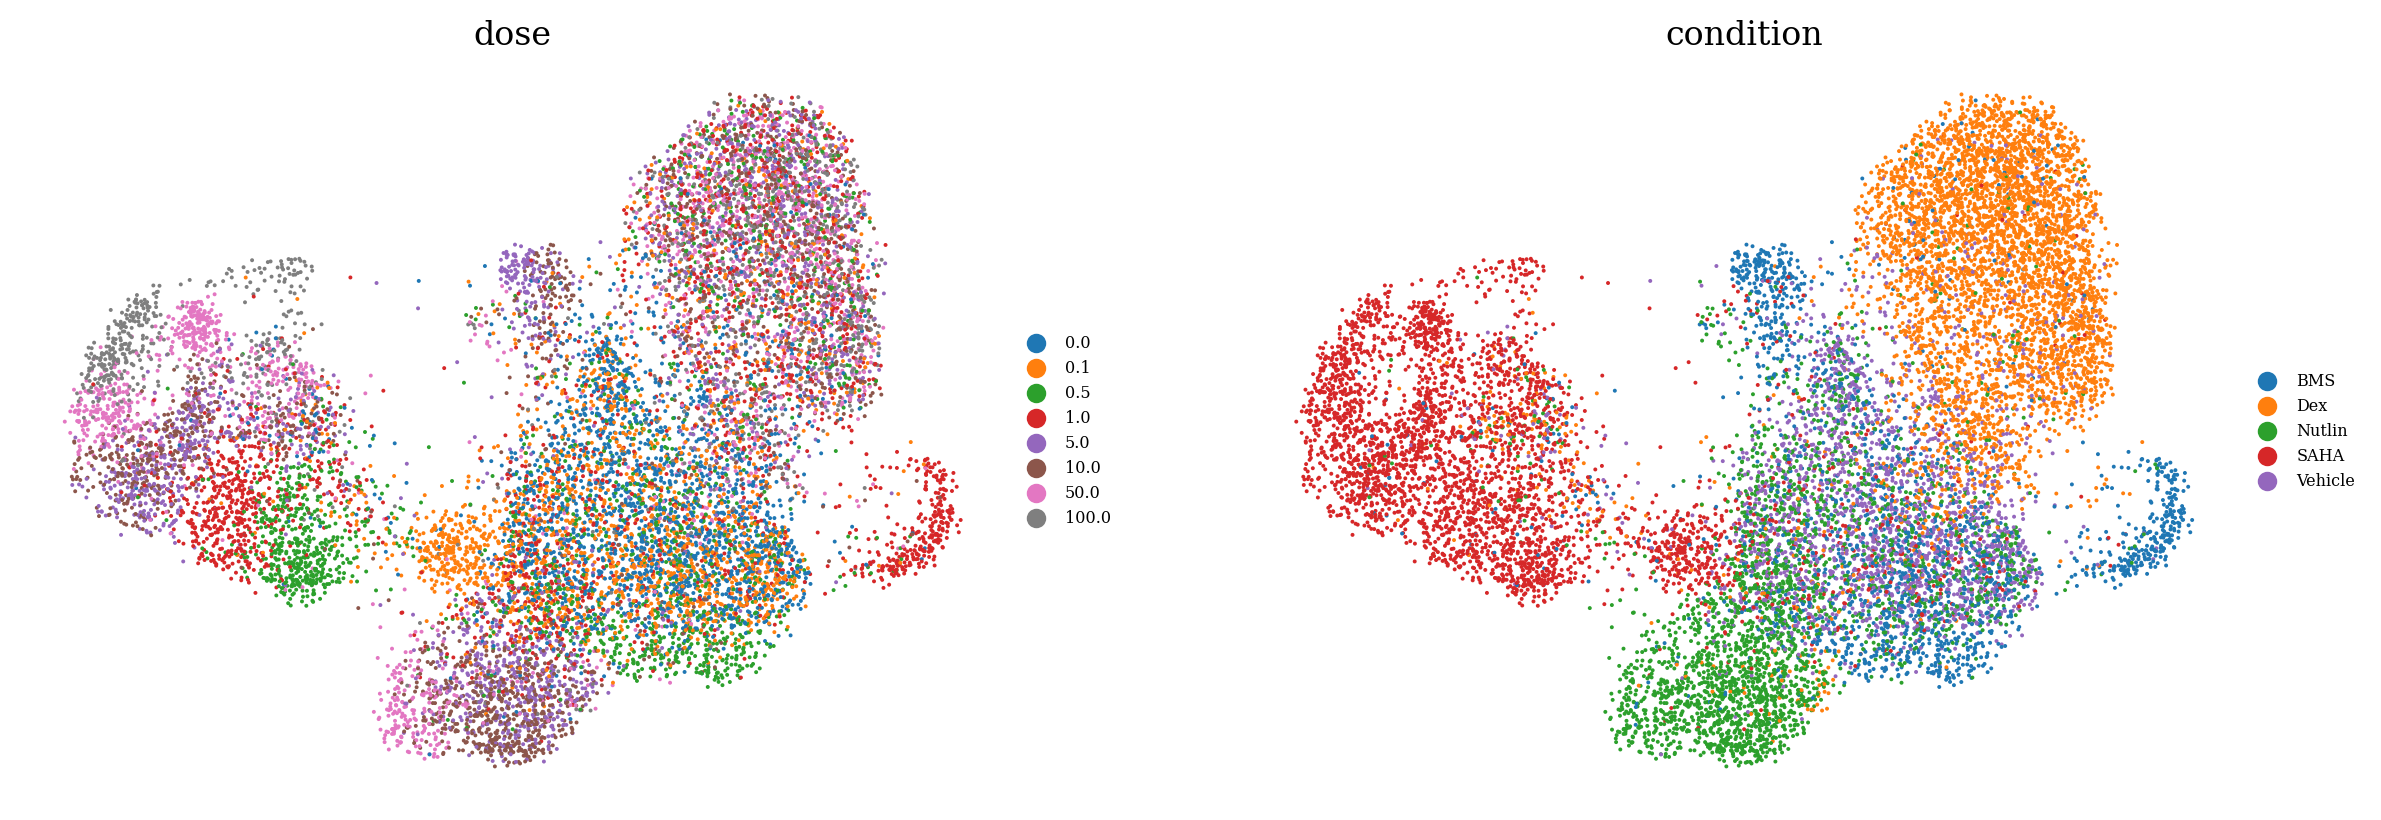

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

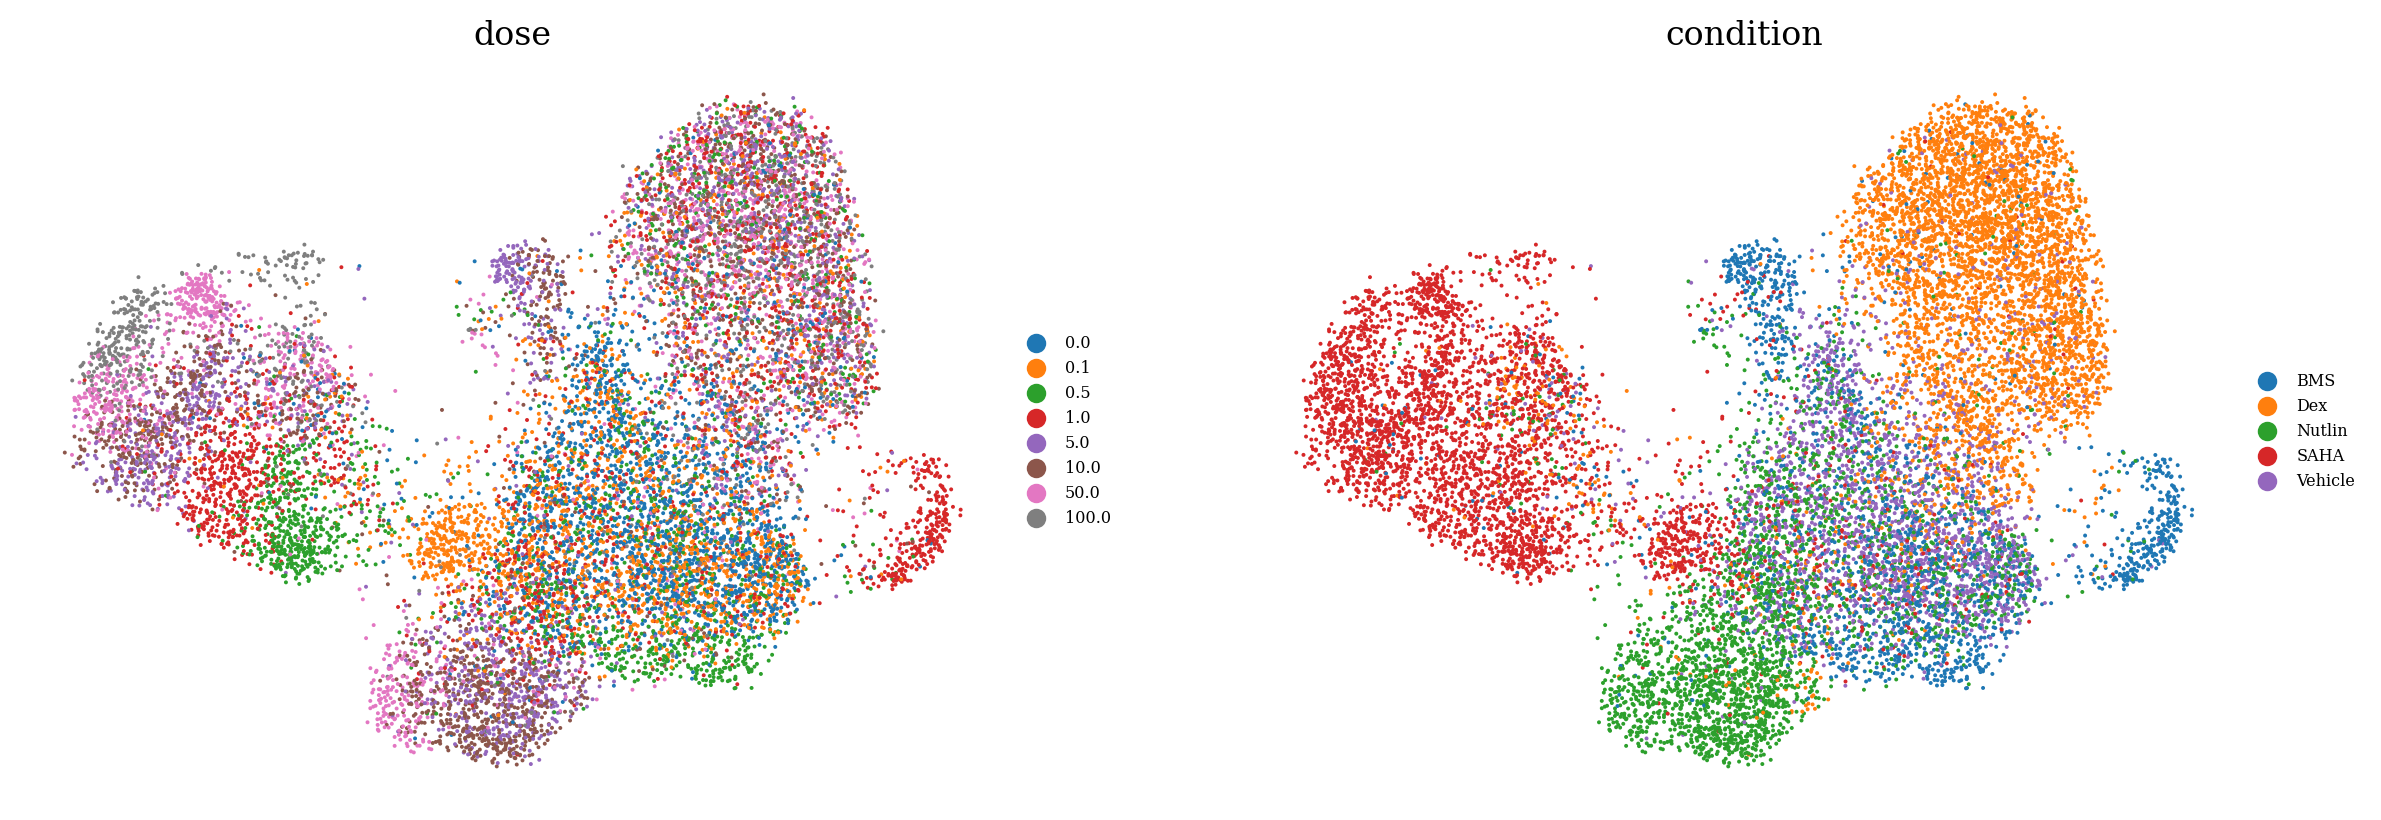

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  3%|▎         | 13/463 [00:00<00:03, 127.51it/s]

  8%|▊         | 37/463 [00:00<00:02, 191.44it/s]

 13%|█▎        | 60/463 [00:00<00:01, 207.50it/s]

 18%|█▊        | 83/463 [00:00<00:01, 215.72it/s]

 23%|██▎       | 106/463 [00:00<00:01, 220.58it/s]

 28%|██▊       | 130/463 [00:00<00:01, 223.96it/s]

 33%|███▎      | 153/463 [00:00<00:01, 225.78it/s]

 38%|███▊      | 177/463 [00:00<00:01, 227.22it/s]

 43%|████▎     | 201/463 [00:00<00:01, 228.30it/s]

 48%|████▊     | 224/463 [00:01<00:01, 228.77it/s]

 54%|█████▎    | 248/463 [00:01<00:00, 229.39it/s]

 59%|█████▊    | 272/463 [00:01<00:00, 229.80it/s]

 64%|██████▍   | 296/463 [00:01<00:00, 230.12it/s]

 69%|██████▉   | 320/463 [00:01<00:00, 230.19it/s]

 74%|███████▍  | 344/463 [00:01<00:00, 230.11it/s]

 79%|███████▉  | 368/463 [00:01<00:00, 230.01it/s]

 85%|████████▍ | 392/463 [00:01<00:00, 229.84it/s]

 90%|████████▉ | 416/463 [00:01<00:00, 230.03it/s]

 95%|█████████▌| 440/463 [00:01<00:00, 230.18it/s]

100%|██████████| 463/463 [00:02<00:00, 199.05it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9843114440573917

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)